# **Red neuronal**

In [1]:
from time import time
import pickle
from multiprocessing import Pool

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

RANDOM_STATE = 10

In [27]:
plt.rcParams['figure.facecolor'] = '#EEF4F3'
plt.rcParams['axes.facecolor'] = '#EEF4F3'
sns.set_theme()

In [2]:
import warnings
warnings.filterwarnings('ignore')

## **Descarga del dataset original**

In [ ]:
!pip install ucimlrepo

In [14]:
from ucimlrepo import fetch_ucirepo

census_income = fetch_ucirepo(id=20)
x = census_income.data.features
y = census_income.data.targets

## **Preprocesamiento con Label Encoding**

A continuación, se aplica el mismo preprocesamiento al conjunto de datos explicado en los notebooks [02_Preprocesamiento.ipynb](https://github.com/daniel-lujan/ModelosII/blob/main/02_Preprocesamiento.ipynb) y [03_Balance_de_clases.ipynb](https://github.com/daniel-lujan/ModelosII/blob/main/03_Balance_de_clases.ipynb), con la única diferencia que no se aplica One-Hot Encoding a las variables categóricas; en su lugar, se aplica [Label Encoding](https://www.mygreatlearning.com/blog/label-encoding-in-python/).

In [15]:
def preprocess_dataset(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    def fill_nan_with_mode(column):
        mode = column.mode()[0]
        return column.fillna(mode)

    def fill_value_with_mode(column, value: str):
        mode = column.mode()[0]
        return column.replace(value, mode)

    X["workclass"] = fill_nan_with_mode(X["workclass"])
    X["native-country"] = fill_nan_with_mode(X["native-country"])

    X["workclass"] = fill_value_with_mode(X["workclass"], "?")
    X["native-country"] = fill_value_with_mode(X["native-country"], "?")

    X["occupation"] = X["occupation"].fillna("?")
    X.drop(columns=["education"], inplace=True)

    y[y == ">50K."] = ">50K"
    y[y == "<=50K."] = "<=50K"

    y[y == ">50K"] = 1
    y[y == "<=50K"] = 0

    y['income'] = y['income'].astype(int)

    # Label encoding
    le = LabelEncoder()
    for c in X.select_dtypes(include='object').columns:
        X[c] = le.fit_transform(X[c])

    # Undersampling
    sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=RANDOM_STATE)
    X, y = sampler.fit_resample(X, y)

    return X, y

x, y = preprocess_dataset(x, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)
sample_weights_train = X_train.pop("fnlwgt")
sample_weights_test = X_test.pop("fnlwgt")

## **Configuración de pruebas**

Para maximizar la exactitud del modelo, se realizaron pruebas variano la cantidad de capas ocultas (entre 1 y 6)  y neuronas por cada una de estas capas (entre 2 y 200).

In [17]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

THREADS = 10 # Number of threads to use for parallelization, approx 50min for 10 threads
MAX_ITERS = 2000 # Max epochs

In [18]:
def run_test(layers_size: list[int]) -> dict:
    t = time()

    net = MLPClassifier(
        hidden_layer_sizes=layers_size,
        activation="logistic",
        max_iter=MAX_ITERS,
        random_state=RANDOM_STATE,
    )
    net.fit(X_train.values, y_train.values)

    train_time = time() - t

    y_pred = net.predict(X_test.values)
    accuracy = accuracy_score(y_test.values, y_pred)

    print(
        f"{bcolors.BOLD}{bcolors.OKCYAN}Test with neurons={layers_size[0]} and hidden_layers={len(layers_size)} finished in {bcolors.WARNING}{time()-t:.2f} seconds.{bcolors.ENDC}"
    )

    return {
        "neurons": layers_size[0],
        "hidden_layers": len(layers_size),
        "accuracy": accuracy,
        "min_loss": net.loss_,
        "loss": net.loss_curve_,
        "train_time": train_time,
    }


def run_tests_parallel():
    test_neurons = np.linspace(2, 200, 50, dtype=int)
    test_layers = np.linspace(1, 6, 6, dtype=int)

    test_args = [
        [neurons] * layers for neurons in test_neurons for layers in test_layers
    ]

    pool = Pool(THREADS)
    test_results = pool.map(run_test, test_args)

    pool.close()
    pool.join()

    return test_results

# Elimina `and 0` para correr los tests.
# Para hacer uso de la paralelización, se debe correr como script .py desde la terminal.
if __name__ == "__main__" and 0:
    t = time()

    print(f"{bcolors.BOLD}{bcolors.OKGREEN}Running tests...{bcolors.ENDC}")

    test_res = run_tests_parallel()

    print(
        f"{bcolors.BOLD}{bcolors.OKGREEN}All tests finished in {bcolors.WARNING}{time()-t:.2f} seconds.{bcolors.ENDC}"
    )

    loss = {}

    for res in test_res:
        loss[str((res["neurons"], res["hidden_layers"]))] = res.pop("loss")

    with open("loss.pkl", "wb") as f:
        pickle.dump(loss, f)

    print(f"{bcolors.BOLD}{bcolors.OKGREEN}Loss curves saved to loss.pkl{bcolors.ENDC}")

    df = pd.DataFrame(columns=["neurons", "hidden_layers", "accuracy", "min_loss"])
    df = pd.concat([df, pd.DataFrame.from_records(test_res)], ignore_index=True)
    df.to_csv("test_results.csv", index=False)

    print(
        f"{bcolors.BOLD}{bcolors.OKGREEN}Results saved to test_results.csv{bcolors.ENDC}"
    )


## **Resultados: Mejores hiperparámetros**

In [19]:
test_res = pd.read_csv("test_results.csv")

In [20]:
# Mejores hipérparámetros
test_res.loc[test_res['accuracy'].idxmax()]

neurons          54.000000
hidden_layers     2.000000
accuracy          0.824182
min_loss          0.384834
train_time       58.360968
Name: 79, dtype: float64

La configuración con mejor desempeño fue con 2 capas ocultas con 54 neuronas cada una, logrando un ~82.42% de exactitud.

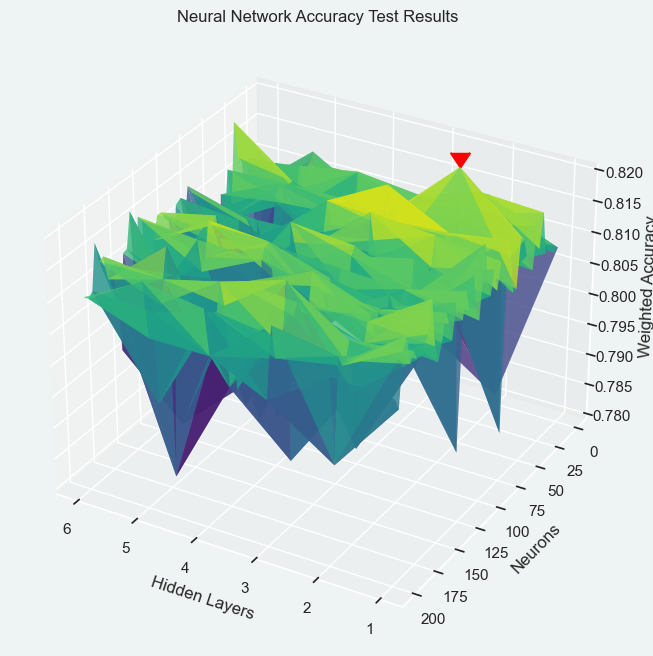

In [29]:
ax = plt.axes(projection ='3d')
ax.figure.set_size_inches(10, 8)

# Filtrar solo los resultados con accuracy >= 0.78
test_res = test_res[test_res["accuracy"] >= 0.78]

z = test_res['accuracy'].values
x = test_res["hidden_layers"].values
y = test_res["neurons"].values

_max = test_res.loc[test_res['accuracy'].idxmax()]

ax.plot_trisurf(x, y, z, linewidth=0, antialiased=True, shade=False, cmap=cm.viridis, alpha=0.8)
ax.scatter(_max["hidden_layers"], _max["neurons"], _max["accuracy"], s=200, marker=7, color="red")

ax.set_zlim(0.78, 0.82)

plt.xlabel("Hidden Layers")
plt.ylabel("Neurons")
ax.set_zlabel("Weighted Accuracy")
plt.title("Neural Network Accuracy Test Results")

ax.view_init(30, 120)

plt.savefig("nn_accuracy.png", dpi=300)

### **Loss curve**

In [22]:
with open("loss.pkl", "rb") as f:
    loss = pickle.load(f)

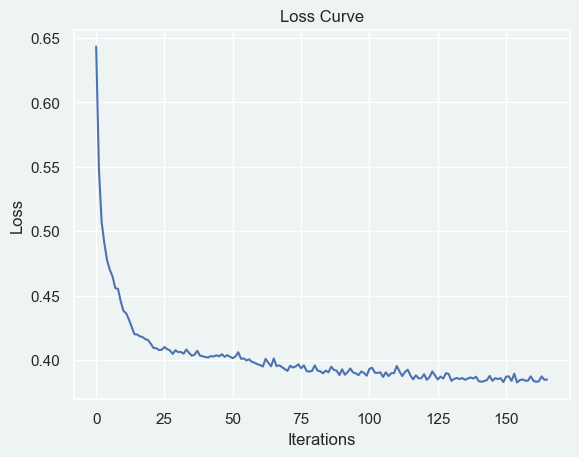

In [36]:
plt.plot(loss[str((int(_max["neurons"]), int(_max["hidden_layers"])))], label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")

plt.savefig("loss_curve.png", dpi=300)

## **Mejor Red Neuronal**

In [25]:
net = MLPClassifier(activation="logistic", hidden_layer_sizes=(int(_max["neurons"]),) * int(_max["hidden_layers"]), max_iter=MAX_ITERS, random_state=RANDOM_STATE).fit(X_train.values, y_train.values)

In [26]:
net.score(X_test.values, y_test.values, sample_weight=sample_weights_test)

0.824181946709227

In [33]:
y_pred = net.predict(X_test.values)
y_pred_proba = net.predict_proba(X_test.values)[:,1]

In [34]:
with open("net-prob.p", "wb") as f:
    pickle.dump(y_pred, f)

with open("net-pred-proba.p", "wb") as f:
    pickle.dump(y_pred_proba, f)